In [3]:
import numpy as np
import astropy.io.ascii as at
import matplotlib.pyplot as plt
%matplotlib inline
from astroML import time_series

# For now, make sure hypra is on the k2 branch!
import hypra.prot.fix_kepler
import hypra.prot.time_series
reload(hypra.prot.time_series)

from k2spin import lc
from k2spin import k2io
from k2spin import plot
from k2spin import prot
reload(lc)
reload(plot)

<module 'k2spin.plot' from '/home/stephanie/code/python/k2spin/plot.pyc'>

First, read in the lightcurve and run necessary corrections

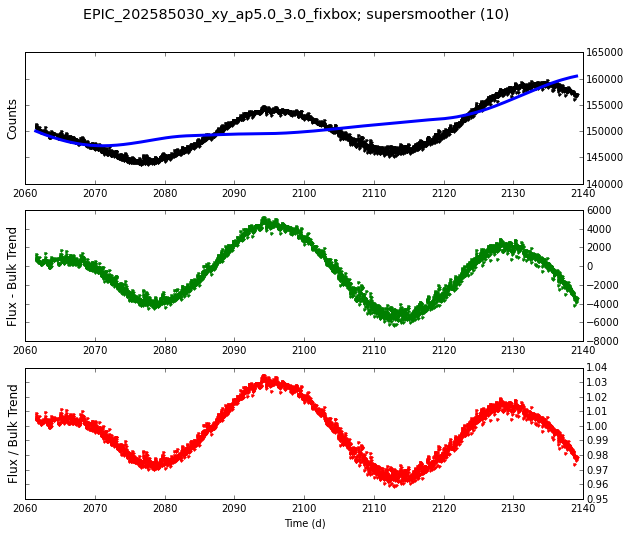

In [59]:
lc_dir = "/home/stephanie/code/python/k2spin/lcs/"
#filename = "EPIC_202521690_xy_ap5.0_3.0_fixbox.dat" # the one that works
#filename = "EPIC_203046199_xy_ap5.0_3.0_fixbox.dat" # solid signal, variable envelope
filename = "EPIC_202585030_xy_ap5.0_3.0_fixbox.dat" # long Prot + linear trend
#filename = "EPIC_203033414_xy_ap5.0_3.0_fixbox.dat" # noisy, medium Prot
#filename = "EPIC_203036352_xy_ap5.0_3.0_fixbox.dat" # strong Prot ~0.9d
#filename = "EPIC_203042487_xy_ap5.0_3.0_fixbox.dat" # very mixed
#filename = "EPIC_202533810_xy_ap5.0_3.0_fixbox.dat" # very mixed


lc_out = k2io.read_double_aperture(lc_dir+filename)
time, fluxes, unc_fluxes, x_pos, y_pos, qual_flux, apertures = lc_out
    
detrend_kwargs={"kind":"supersmoother","phaser":10}
use_time = (time>2002)
light_curve = lc.LightCurve(time[use_time], fluxes[1][use_time], 
                            unc_fluxes[1][use_time], 
                            x_pos[use_time], y_pos[use_time],
                            name=filename[:-4],
                            detrend_kwargs=detrend_kwargs)
#light_curve.choose_initial()
#light_curve.correct_and_fit()


t = light_curve.time
y = light_curve.flux
dy = light_curve.unc_flux

t = light_curve.time
y = light_curve.det_flux
dy = light_curve.det_unc



In [60]:
cadence = np.median(np.diff(t))
six_hr = 0.25 / cadence
six_hr_std = np.zeros_like(y)
six_hr_half = int(six_hr / 2.0)
for i in range(six_hr_half,len(y)-six_hr_half):
    six_hr_std[i] = np.std(y[i-six_hr_half:i+six_hr_half])
    
print np.median(six_hr_std), np.std(y), np.std(y) / np.median(six_hr_std)

0.00159348974897 0.0184347264842 11.5687763264


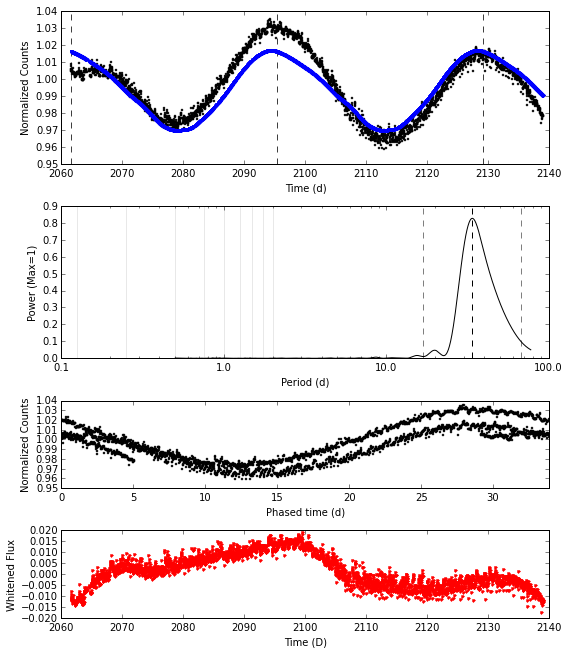

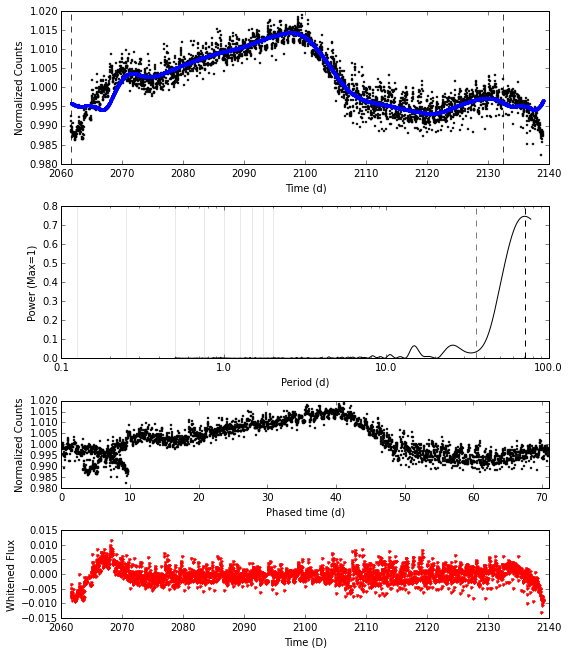

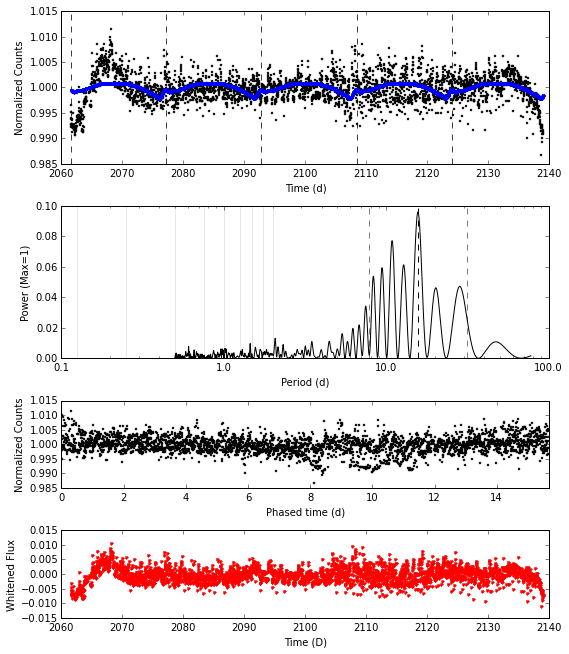

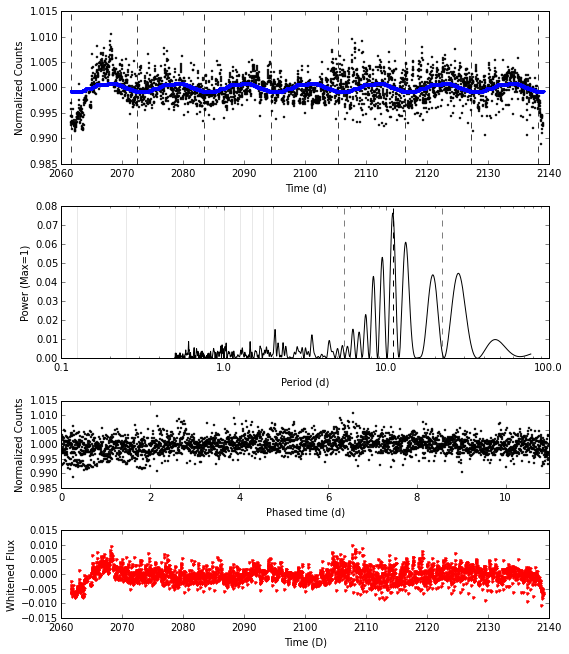

In [61]:
reload(prot)
det_kwargs = {"kind":"supersmoother","filename":light_curve.name}
#det_kwargs = {"kind":"boxcar","phaser":six_hr*4}
max_prot = t[-1] - t[0]
flat_flux, flat_unc = prot.detrend_for_correction(t, y, dy, 
                                                  prot_lims=[0.5,max_prot],
                                                  to_plot=True,
                                                  **det_kwargs)

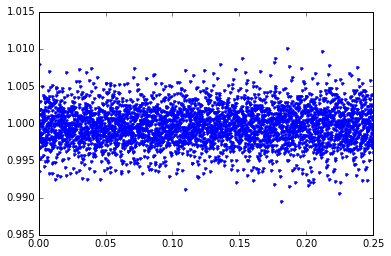

In [62]:
phased_time = t % 0.25
plt.plot(phased_time, flat_flux,'b.')

In [63]:
light_curve.use_flux = y
light_curve.use_unc = dy
light_curve._xy_correct(correct_with=flat_flux, n_closest=40)

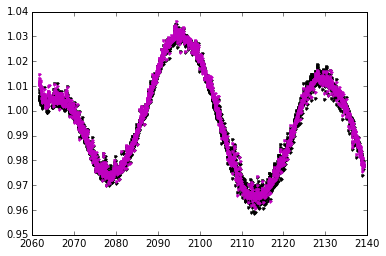

In [64]:
plt.plot(t, y, 'k.')
plt.plot(t, light_curve.corrected_flux, 'm.')

In [65]:
ls_out = prot.run_ls(t, light_curve.corrected_flux, 
                     light_curve.corrected_unc, threshold=0.5,
                     prot_lims=[0.1,max_prot], run_bootstrap=True)

33.8501387295


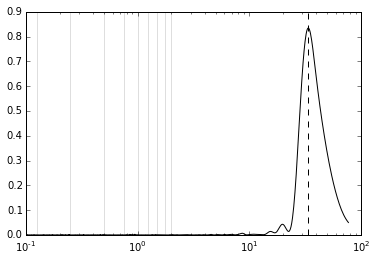

In [66]:
plt.plot(ls_out[2], ls_out[3], 'k-')
plt.xscale("log")
plt.xlim(0.1,100)
ax = plt.gca()
ax.axvline(ls_out[0],color='k',ls='--')
harmonics = np.append(0.125,np.arange(0.25,2.1,0.25))
for harm in harmonics:
    ax.axvline(harm, color="LightGrey", linestyle="-",
               alpha=0.75, zorder=-111)
print ls_out[0]